In [390]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from torch.utils.data import TensorDataset, DataLoader, Subset
# import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

warnings.filterwarnings("ignore")

In [391]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

No GPU available!


# Read the data file extracted from feature_extraction part

In [392]:
# This is for use data file generated in feature_extraction
df = pd.read_csv('../data/2011-2018_40*40_rectangular_mode_features.csv', dtype=float)

# The result of report is one attempt, this is for recurring similar results in report
# df = pd.read_csv('../data/recurring_report.csv', dtype=float)

In [393]:
df.columns

Index(['injection_number', 'injection_vol_sum', 'injection_psi_sum',
       'injection_depth_avg', 'injection_above_basement_number',
       'injection_under_basement_number',
       'injection_close_to_basement_500_number',
       'injection_close_to_basement_1000_number', 'active_well_number',
       'well_depth_avg', 'well_above_basement_number',
       'well_under_basement_number', 'well_close_to_basement_500_number',
       'well_close_to_basement_1000_number', 'depth_to_basement_avg',
       'hf_number', 'hf_base_water_volume_sum', 'hf_base_nowater_volume_sum',
       'earthquake_occurence'],
      dtype='object')

In [394]:
df.rename(columns = {"earthquake_occurence":"class"}, inplace=True)
df['class'].value_counts()

0.0    920
1.0    680
Name: class, dtype: int64

# Show the class distribution in data

[Text(0, 0, '0'), Text(0, 0, '1')]

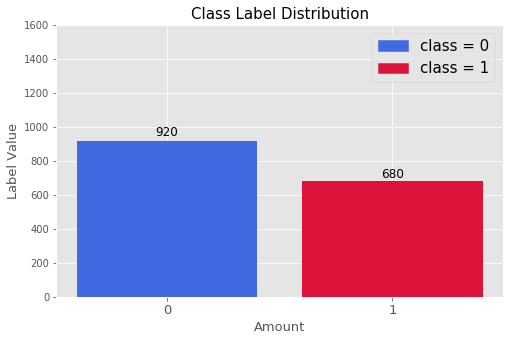

In [395]:
plt.style.use("ggplot")

x = ['0', '1']
y = df['class'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x=x, height=y, color=['royalblue', 'crimson'])
ax.set_title("Class Label Distribution", fontsize=15)
ax.set_ylim(0,1600)

xticks = ax.get_xticks()
for i in range(len(y)):
    xy = (xticks[i], y[i] * 1.03)
    s = str(y[i])
    ax.annotate(
        s=s,
        xy=xy,
        fontsize=12,
        color="black",
        ha="center",
        va="baseline"
    )
    
ax.set_xlabel("Amount", fontsize=13)
ax.set_ylabel("Label Value", fontsize=13)
    
red_patch = mpatches.Patch(color='crimson', label='class = 1')
blue_patch = mpatches.Patch(color='royalblue', label='class = 0')
ax.legend(handles=[blue_patch, red_patch], fontsize=15)
ax.set_xticklabels(labels=x, fontsize=13)

# Show the seismic regions and nonseismic regions in the data we extracted.

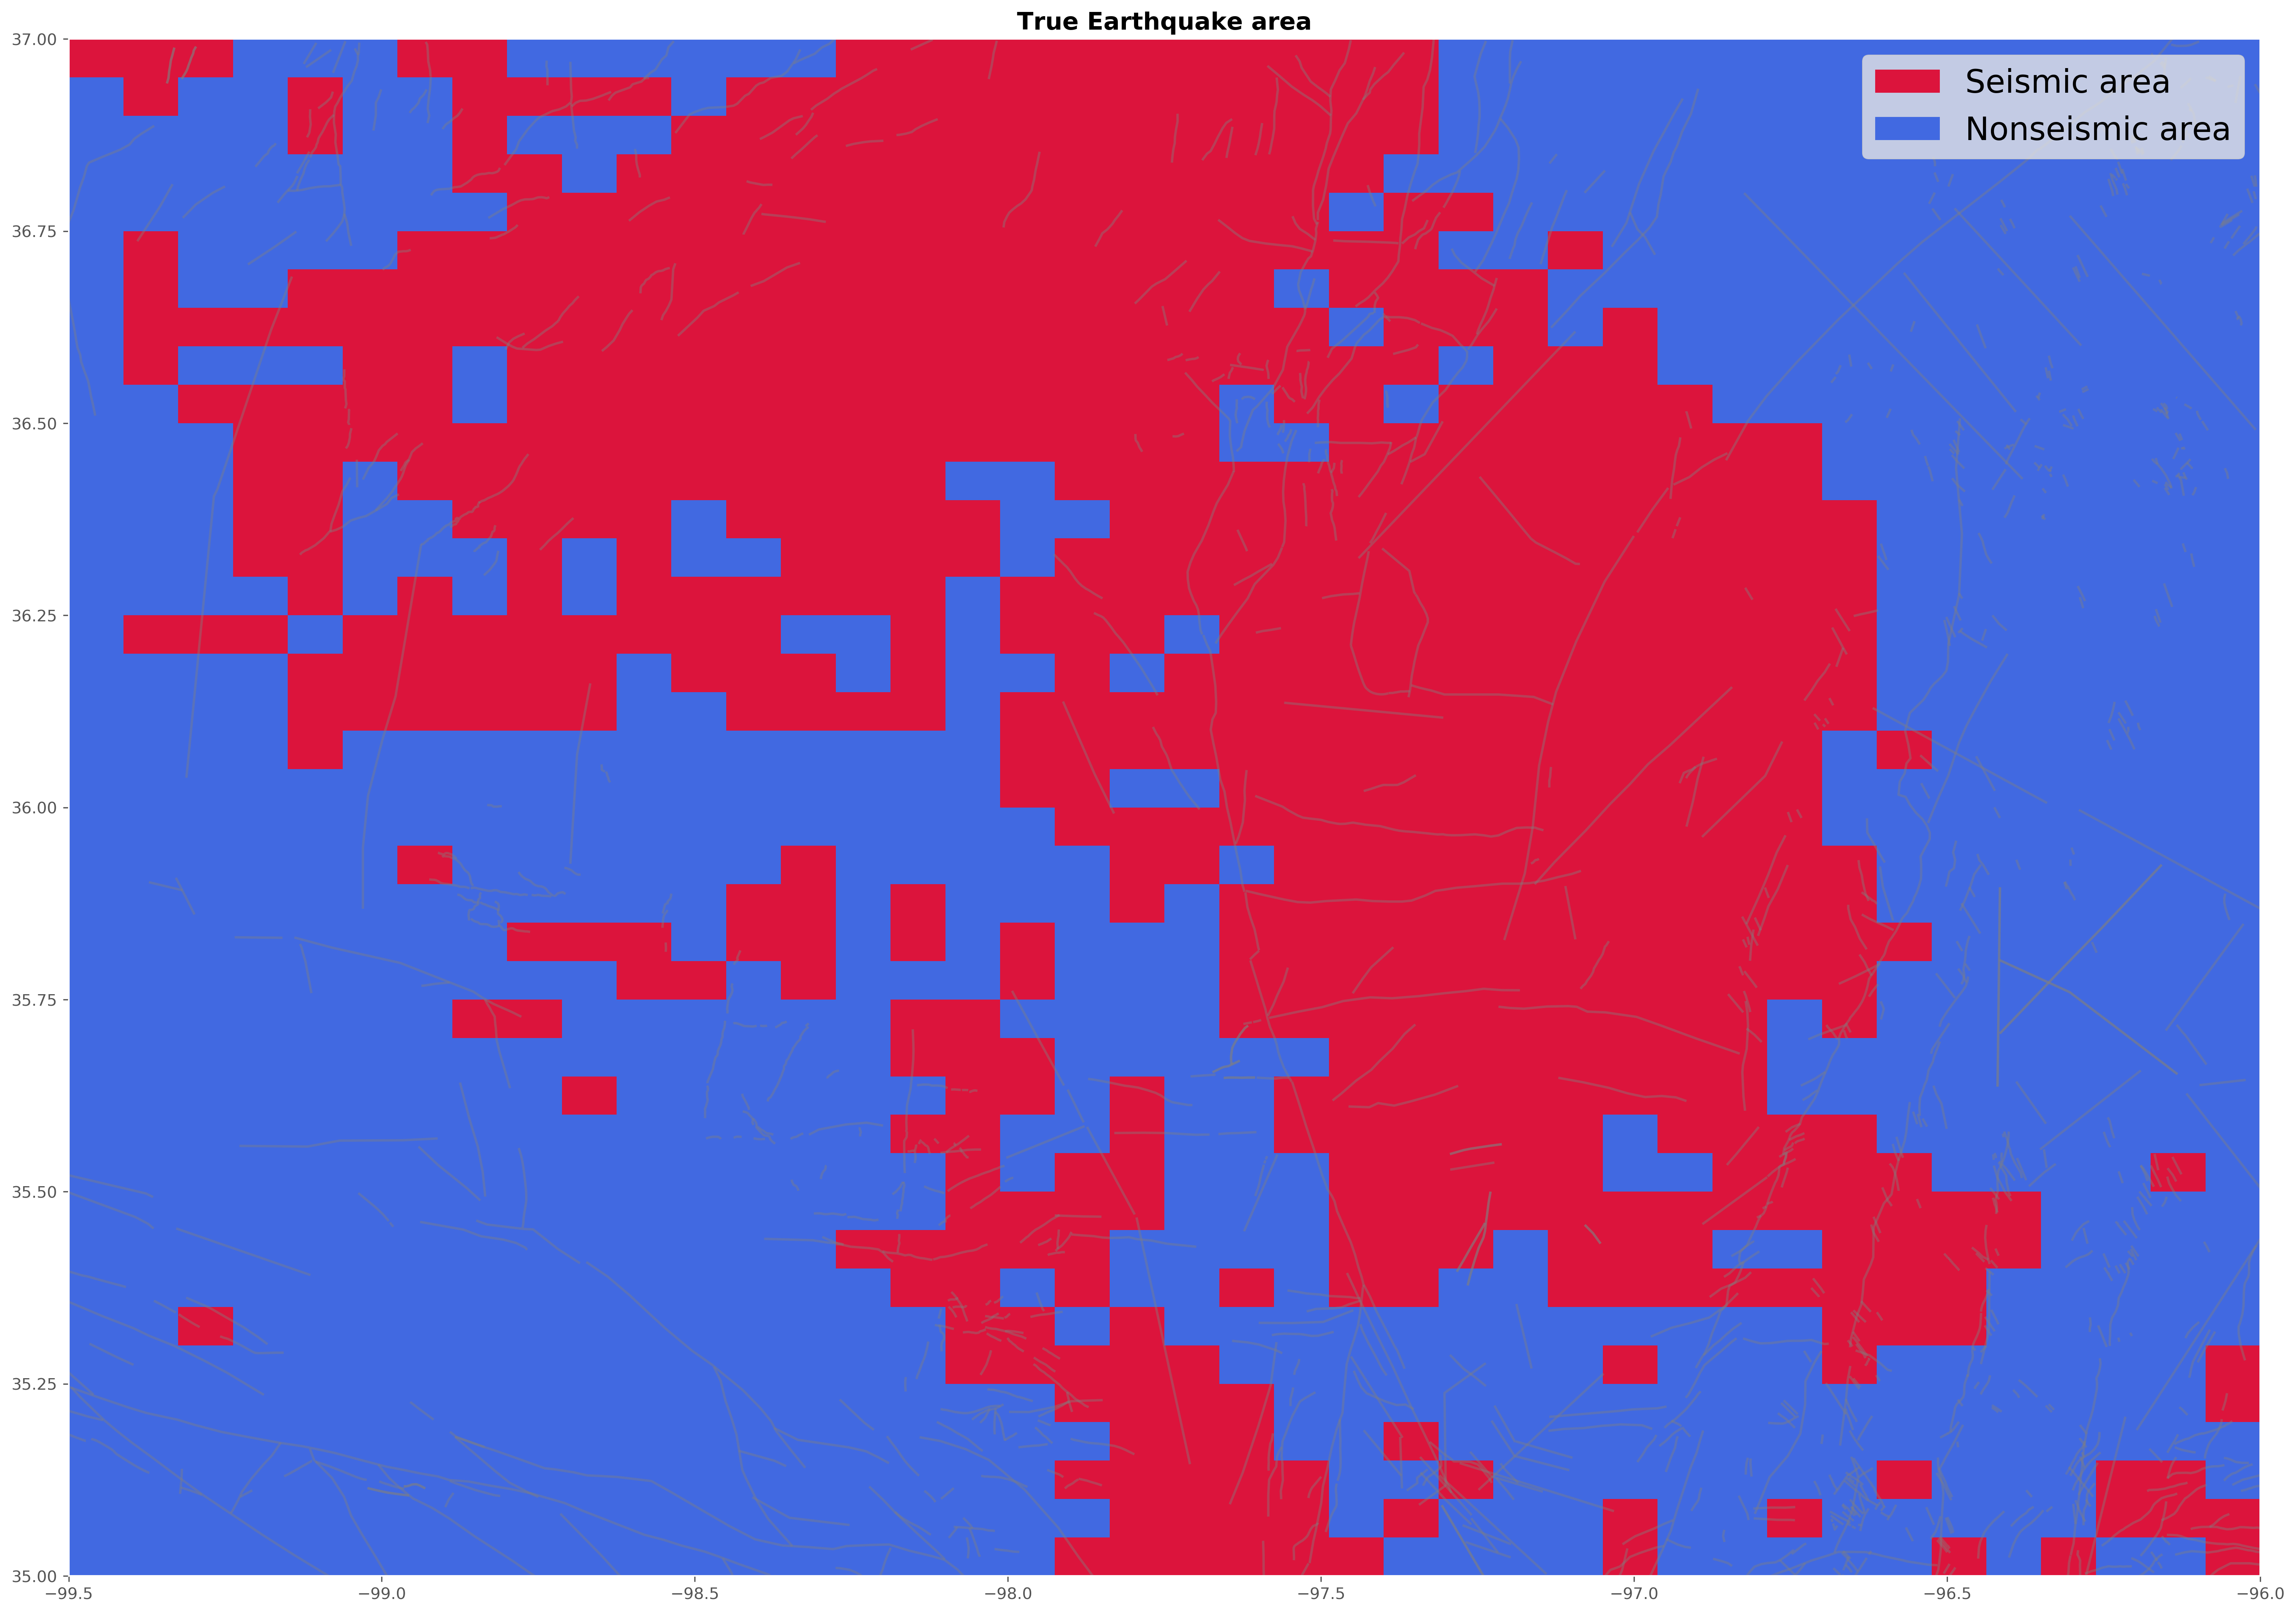

In [396]:
labels = df['class']

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1
# m, n = (41, 41)
x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,1,1)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('../datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')

lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = labels
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
# point = Line2D([0], [0], marker='o', color='black', label='Earthquake Occurence',
#                           markerfacecolor='w', markersize=20)


ax1.legend(handles=[red_patch, blue_patch], fontsize=20)      
ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')
plt.tight_layout()
plt.show()

# Show the pearson correlation and multicollinearity in candidate features

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text yticklabel objects>)

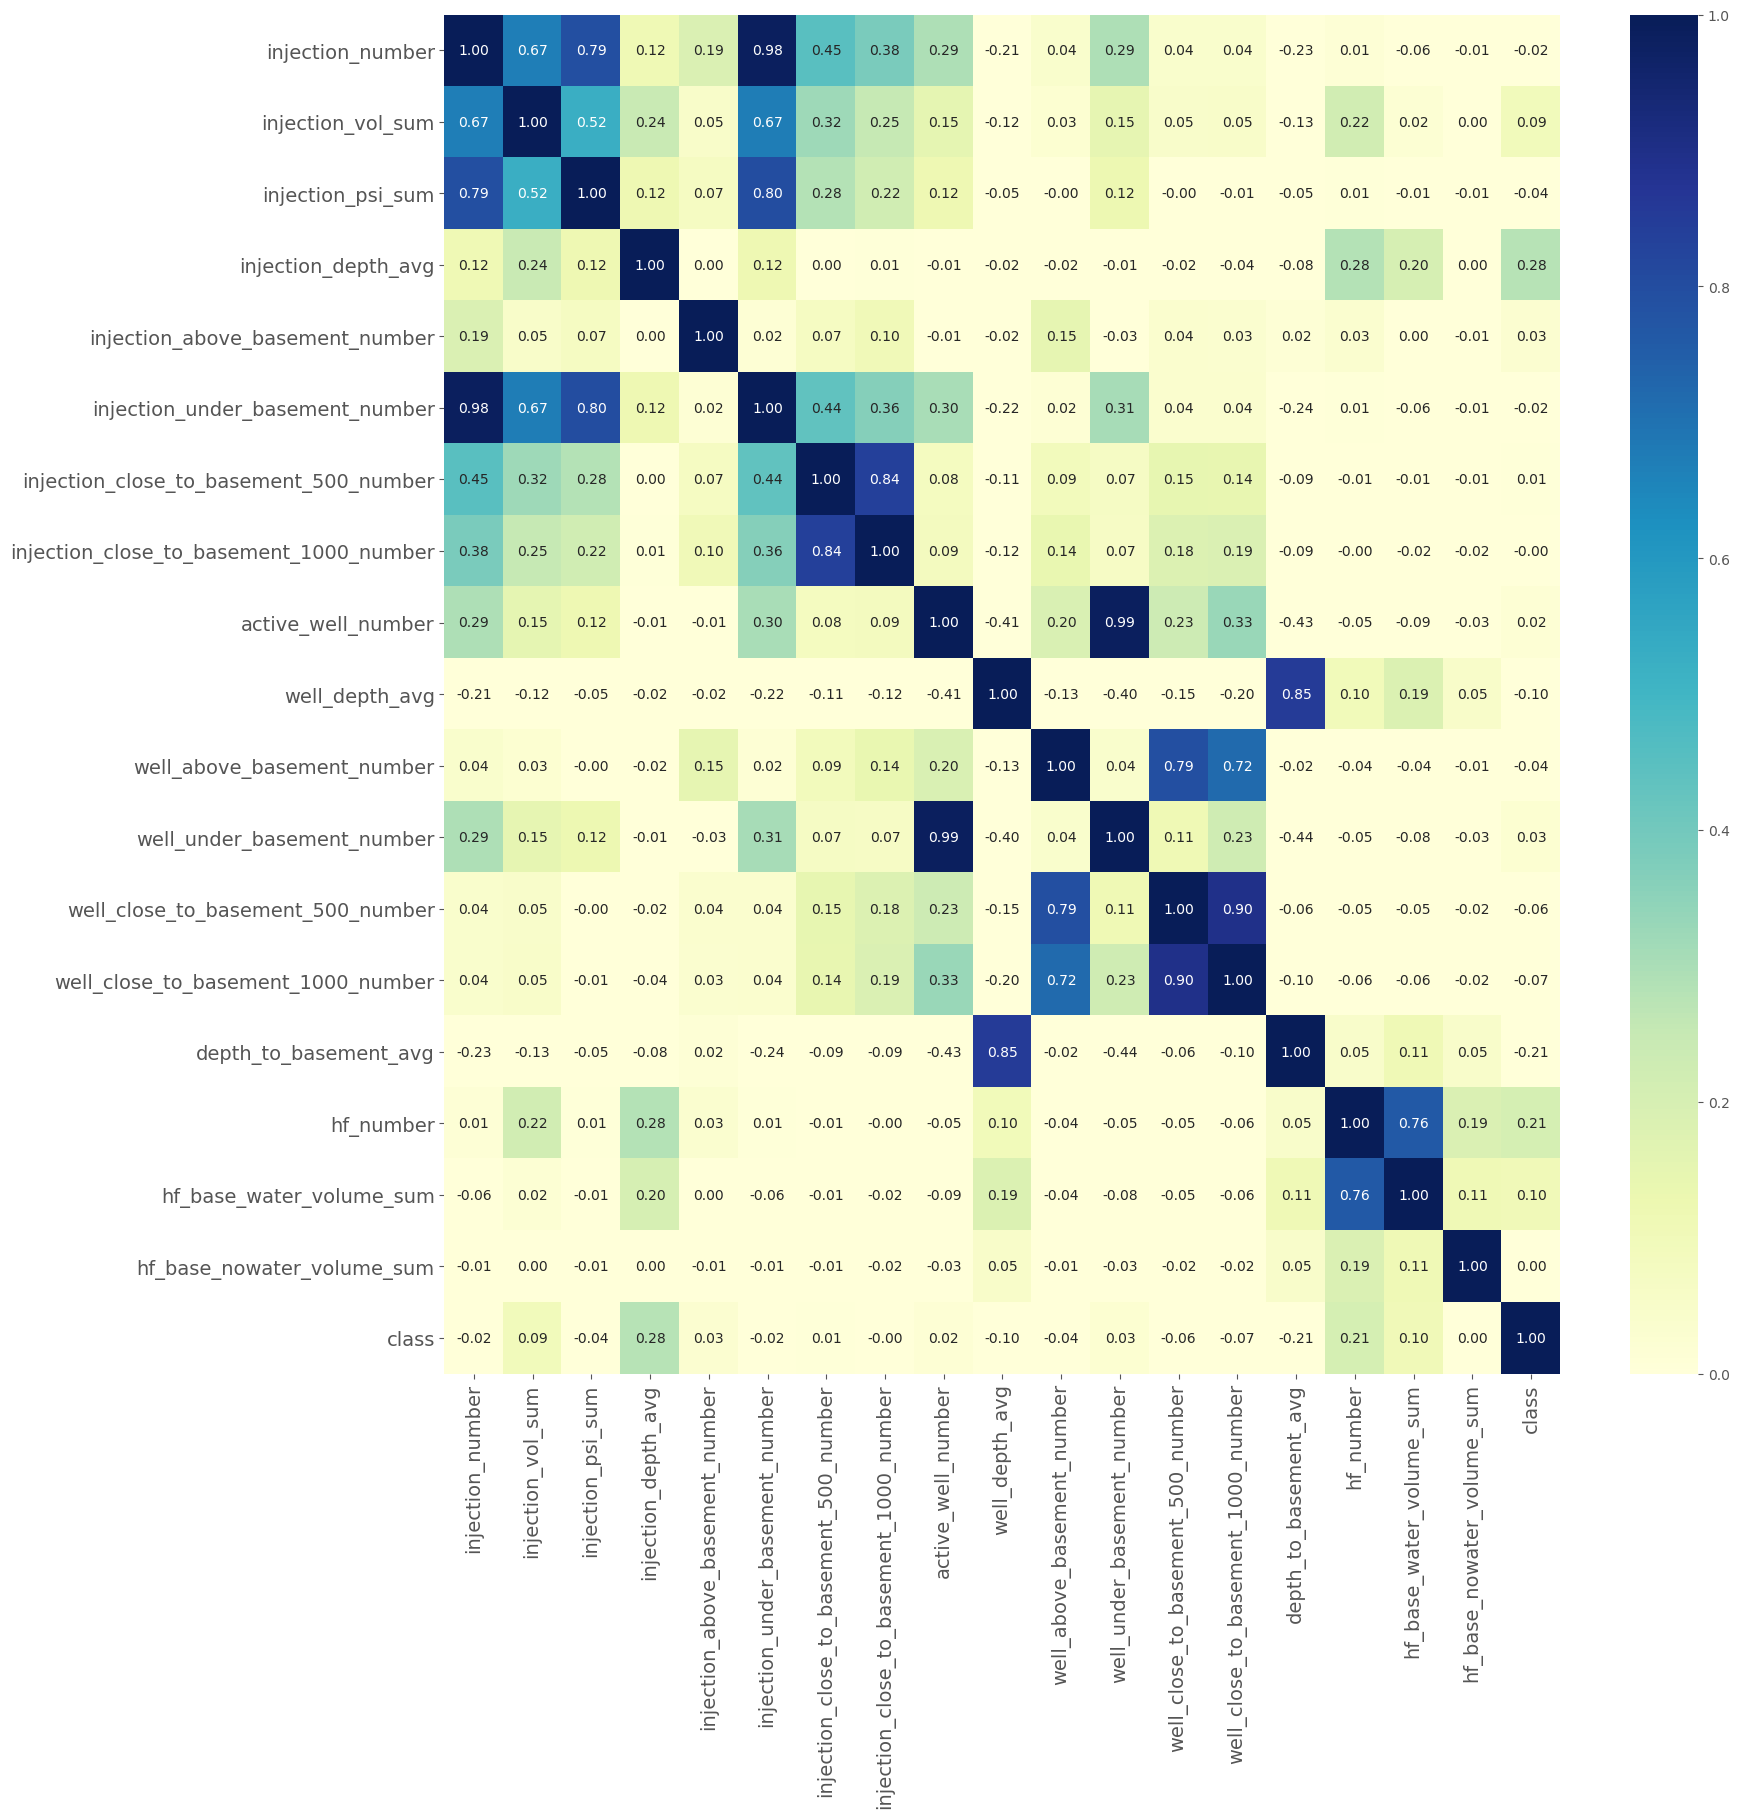

In [397]:
import seaborn as sns
data=df
# pearson correlation calculation
dcorr = data.corr()
plt.figure(figsize=(18, 18),dpi=100)
fig = sns.heatmap(data=dcorr, annot=True, fmt=".2f", vmin=0, vmax=1, cmap="YlGnBu")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Stepwise Regression Feature Selection

In [398]:
# creating function to get model statistics
def get_stats():
    """
    get model statistics
    """
    x = df[x_columns]
    y = df['class']
    
    mean_value = np.mean(x, axis=0)
    std_value = np.std(x, axis=0)

    feature_number = len(x_columns)
    # X_train
    for i in range(0, feature_number):
        feature_name = x_columns[i]
        x[feature_name]= (x[feature_name] - mean_value[feature_name]) / std_value[feature_name]

    results = sm.Logit(y, x).fit()
    print(results.summary())

def checkVIF_new(df):
    """
    check VIF
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    df['c'] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    VIF = VIF[VIF.feature != 'c']
    max_VIF = max(VIF_list)
    print(VIF)

def remove_feature(feature):
    """
    remove the feature and get model statistics, VIF checking
    """
    x_columns.remove(feature)
    if len(x_columns) > 0:
        get_stats()
        checkVIF_new(df[x_columns])

In [399]:
all_features = df.columns.tolist()[:-1]
x_columns = []
print('all_features:\n ', all_features)
print('x_columns:\n', x_columns)

all_features:
  ['injection_number', 'injection_vol_sum', 'injection_psi_sum', 'injection_depth_avg', 'injection_above_basement_number', 'injection_under_basement_number', 'injection_close_to_basement_500_number', 'injection_close_to_basement_1000_number', 'active_well_number', 'well_depth_avg', 'well_above_basement_number', 'well_under_basement_number', 'well_close_to_basement_500_number', 'well_close_to_basement_1000_number', 'depth_to_basement_avg', 'hf_number', 'hf_base_water_volume_sum', 'hf_base_nowater_volume_sum']
x_columns:
 []


In [400]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_base_nowater_volume_sum
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1599
Method:                           MLE   Df Model:                            0
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                -0.01656
Time:                        19:20:52   Log-Likelihood:                -1109.0
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_nowater_volume_sum    

In [401]:
remove_feature('hf_base_nowater_volume_sum')

In [402]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_base_water_volume_sum
Optimization terminated successfully.
         Current function value: 0.687286
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1599
Method:                           MLE   Df Model:                            0
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:               -0.007966
Time:                        19:20:52   Log-Likelihood:                -1099.7
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum     0.2448 

In [403]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_number
Optimization terminated successfully.
         Current function value: 0.660442
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1598
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.03140
Time:                        19:20:52   Log-Likelihood:                -1056.7
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.256e-16
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum    -0.5175      0.107     

In [404]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  depth_to_basement_avg
Optimization terminated successfully.
         Current function value: 0.637210
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1597
Method:                           MLE   Df Model:                            2
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.06548
Time:                        19:20:52   Log-Likelihood:                -1019.5
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.500e-32
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum    -0.4366    

In [405]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_close_to_basement_1000_number
Optimization terminated successfully.
         Current function value: 0.633482
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1596
Method:                           MLE   Df Model:                            3
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.07094
Time:                        19:20:52   Log-Likelihood:                -1013.6
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.436e-33
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
hf_bas

In [406]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_close_to_basement_500_number
Optimization terminated successfully.
         Current function value: 0.633413
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.07104
Time:                        19:20:52   Log-Likelihood:                -1013.5
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.715e-32
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
hf_base

In [407]:
remove_feature('well_close_to_basement_500_number')

Optimization terminated successfully.
         Current function value: 0.633482
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1596
Method:                           MLE   Df Model:                            3
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.07094
Time:                        19:20:52   Log-Likelihood:                -1013.6
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.436e-33
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
hf_base_water_volume_sum              -0.4463      0.108    

In [408]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_under_basement_number
Optimization terminated successfully.
         Current function value: 0.631707
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.07355
Time:                        19:20:52   Log-Likelihood:                -1010.7
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.158e-33
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
hf_base_water_

In [409]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_above_basement_number
Optimization terminated successfully.
         Current function value: 0.631531
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.07380
Time:                        19:20:53   Log-Likelihood:                -1010.5
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 5.957e-33
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
hf_base_water_

In [410]:
remove_feature('well_above_basement_number')

Optimization terminated successfully.
         Current function value: 0.631707
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.07355
Time:                        19:20:53   Log-Likelihood:                -1010.7
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.158e-33
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
hf_base_water_volume_sum              -0.4576      0.108    

In [411]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_depth_avg
Optimization terminated successfully.
         Current function value: 0.619637
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09125
Time:                        19:20:53   Log-Likelihood:                -991.42
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 4.433e-41
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
hf_base_water_volume_sum  

In [412]:
remove_feature('well_close_to_basement_1000_number')

Optimization terminated successfully.
         Current function value: 0.619933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09081
Time:                        19:20:53   Log-Likelihood:                -991.89
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.395e-42
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5690      0.111     -5.105      0.000      

In [413]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  active_well_number
Optimization terminated successfully.
         Current function value: 0.619908
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09085
Time:                        19:20:53   Log-Likelihood:                -991.85
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 6.791e-41
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5698 

In [414]:
remove_feature('active_well_number')

Optimization terminated successfully.
         Current function value: 0.619933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09081
Time:                        19:20:53   Log-Likelihood:                -991.89
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.395e-42
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5690      0.111     -5.105      0.000      

In [415]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_close_to_basement_1000_number
Optimization terminated successfully.
         Current function value: 0.619926
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09082
Time:                        19:20:53   Log-Likelihood:                -991.88
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 6.986e-41
                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [416]:
remove_feature('injection_close_to_basement_1000_number')

Optimization terminated successfully.
         Current function value: 0.619933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09081
Time:                        19:20:53   Log-Likelihood:                -991.89
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.395e-42
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5690      0.111     -5.105      0.000      

In [417]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_close_to_basement_500_number
Optimization terminated successfully.
         Current function value: 0.619924
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09083
Time:                        19:20:53   Log-Likelihood:                -991.88
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 6.974e-41
                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [418]:
remove_feature('injection_close_to_basement_500_number')

Optimization terminated successfully.
         Current function value: 0.619933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09081
Time:                        19:20:53   Log-Likelihood:                -991.89
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.395e-42
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5690      0.111     -5.105      0.000      

In [419]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_under_basement_number
Optimization terminated successfully.
         Current function value: 0.616025
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09655
Time:                        19:20:53   Log-Likelihood:                -985.64
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.489e-43
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_v

In [420]:
remove_feature('well_under_basement_number')

Optimization terminated successfully.
         Current function value: 0.616863
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09532
Time:                        19:20:53   Log-Likelihood:                -986.98
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 7.246e-44
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.6131      0.114     -5.368  

In [421]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_above_basement_number
Optimization terminated successfully.
         Current function value: 0.614830
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                 0.09830
Time:                        19:20:53   Log-Likelihood:                -983.73
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.263e-44
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_v

In [422]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_depth_avg
Optimization terminated successfully.
         Current function value: 0.591579
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            6
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.1324
Time:                        19:20:53   Log-Likelihood:                -946.53
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.971e-59
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum   

In [423]:
remove_feature('injection_above_basement_number')

Optimization terminated successfully.
         Current function value: 0.593074
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.1302
Time:                        19:20:53   Log-Likelihood:                -948.92
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.619e-59
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.5982      0.114     -5.249  

In [424]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_psi_sum
Optimization terminated successfully.
         Current function value: 0.593073
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            6
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.1302
Time:                        19:20:53   Log-Likelihood:                -948.92
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.081e-58
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum     

In [425]:
remove_feature('injection_psi_sum')

Optimization terminated successfully.
         Current function value: 0.593074
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.1302
Time:                        19:20:53   Log-Likelihood:                -948.92
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.619e-59
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.5982      0.114     -5.249  

In [426]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_vol_sum
Optimization terminated successfully.
         Current function value: 0.590683
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            6
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.1337
Time:                        19:20:53   Log-Likelihood:                -945.09
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 4.787e-60
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum     

In [427]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_number
Optimization terminated successfully.
         Current function value: 0.589792
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1592
Method:                           MLE   Df Model:                            7
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.1350
Time:                        19:20:53   Log-Likelihood:                -943.67
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 8.607e-60
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum      

In [428]:
remove_feature('injection_number')

Optimization terminated successfully.
         Current function value: 0.590683
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            6
Date:                Fri, 27 Aug 2021   Pseudo R-squ.:                  0.1337
Time:                        19:20:53   Log-Likelihood:                -945.09
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 4.787e-60
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.5612      0.114     -4.908  

In [429]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

IndexError: list index out of range

Note: We have test all the candidate features so here list index out of range, now x_columns stored the selected features after stepwise regression with VIF checking.

In [435]:
x_columns

['hf_base_water_volume_sum',
 'hf_number',
 'depth_to_basement_avg',
 'well_depth_avg',
 'injection_under_basement_number',
 'injection_depth_avg',
 'injection_vol_sum']

# Show the pearson correlation and multicollinearity in selected features

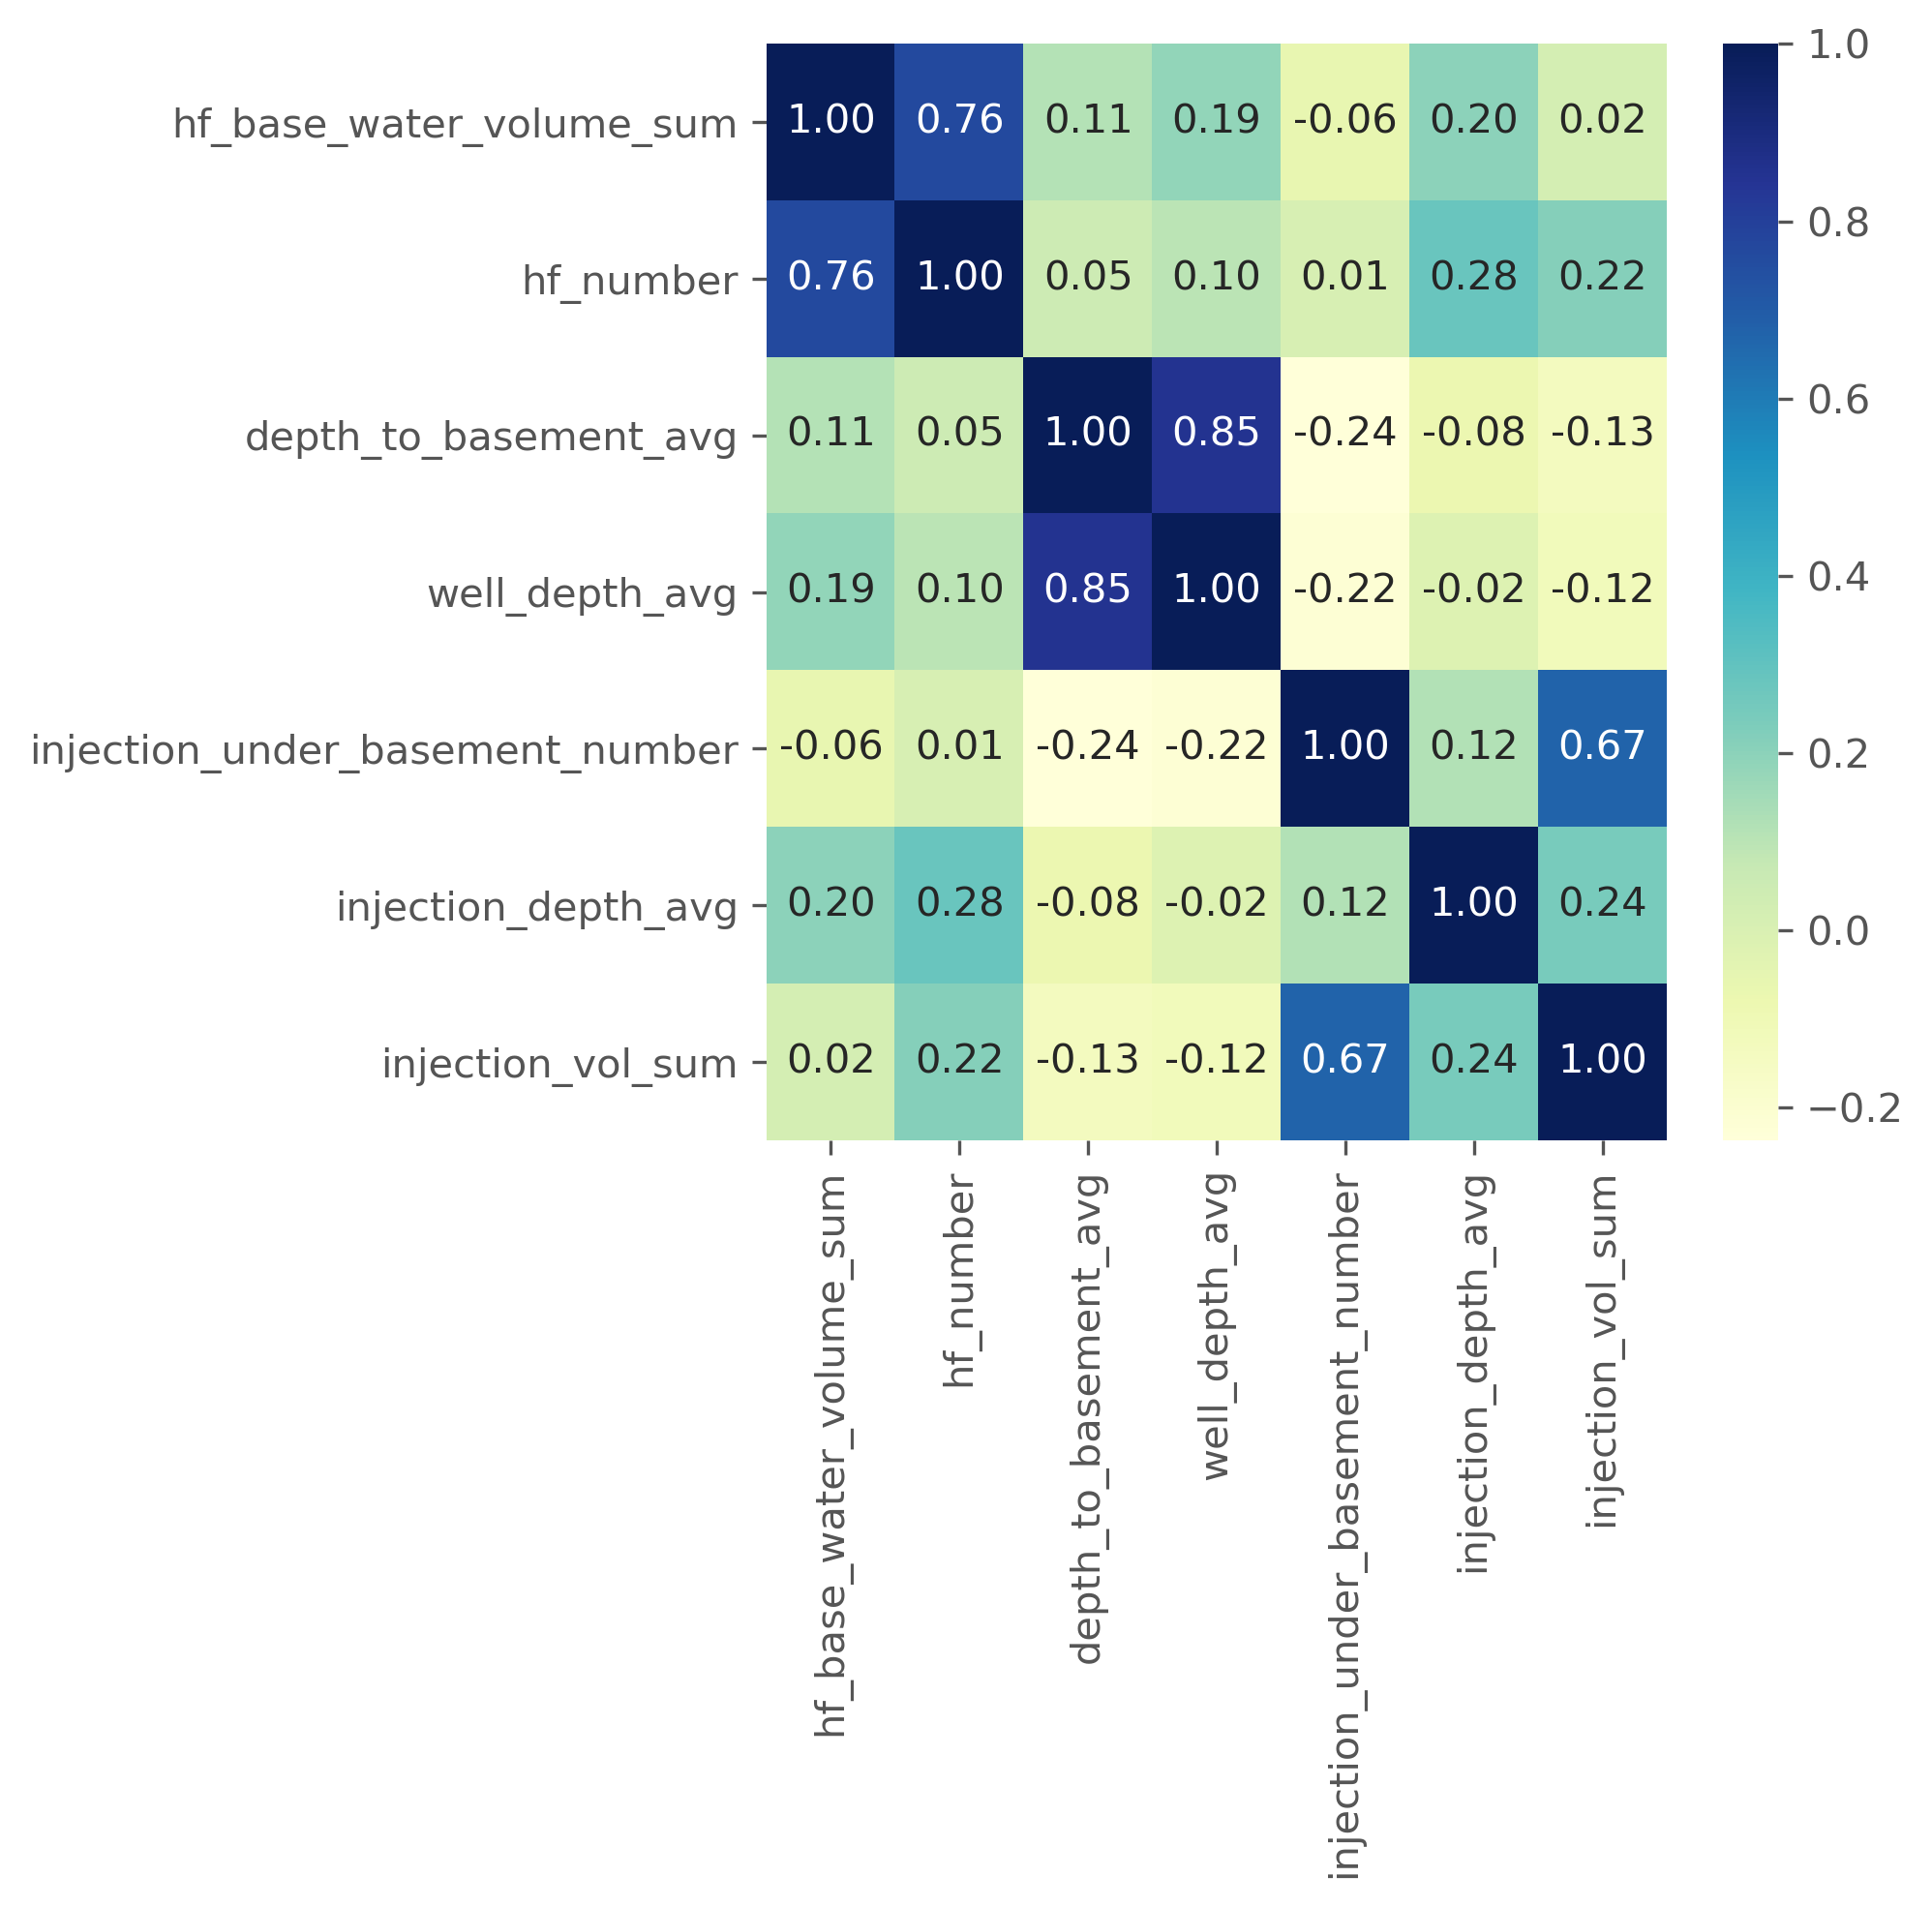

In [436]:
import seaborn as sns
# pearson correlation calculation
dcorr = df[x_columns].corr()
plt.figure(figsize=(5, 5),dpi=300)
fig = sns.heatmap(data=dcorr, annot=True, fmt=".2f", cmap="YlGnBu")

# See the rough correlation for each selected feature with class label (earthquake occurrence)

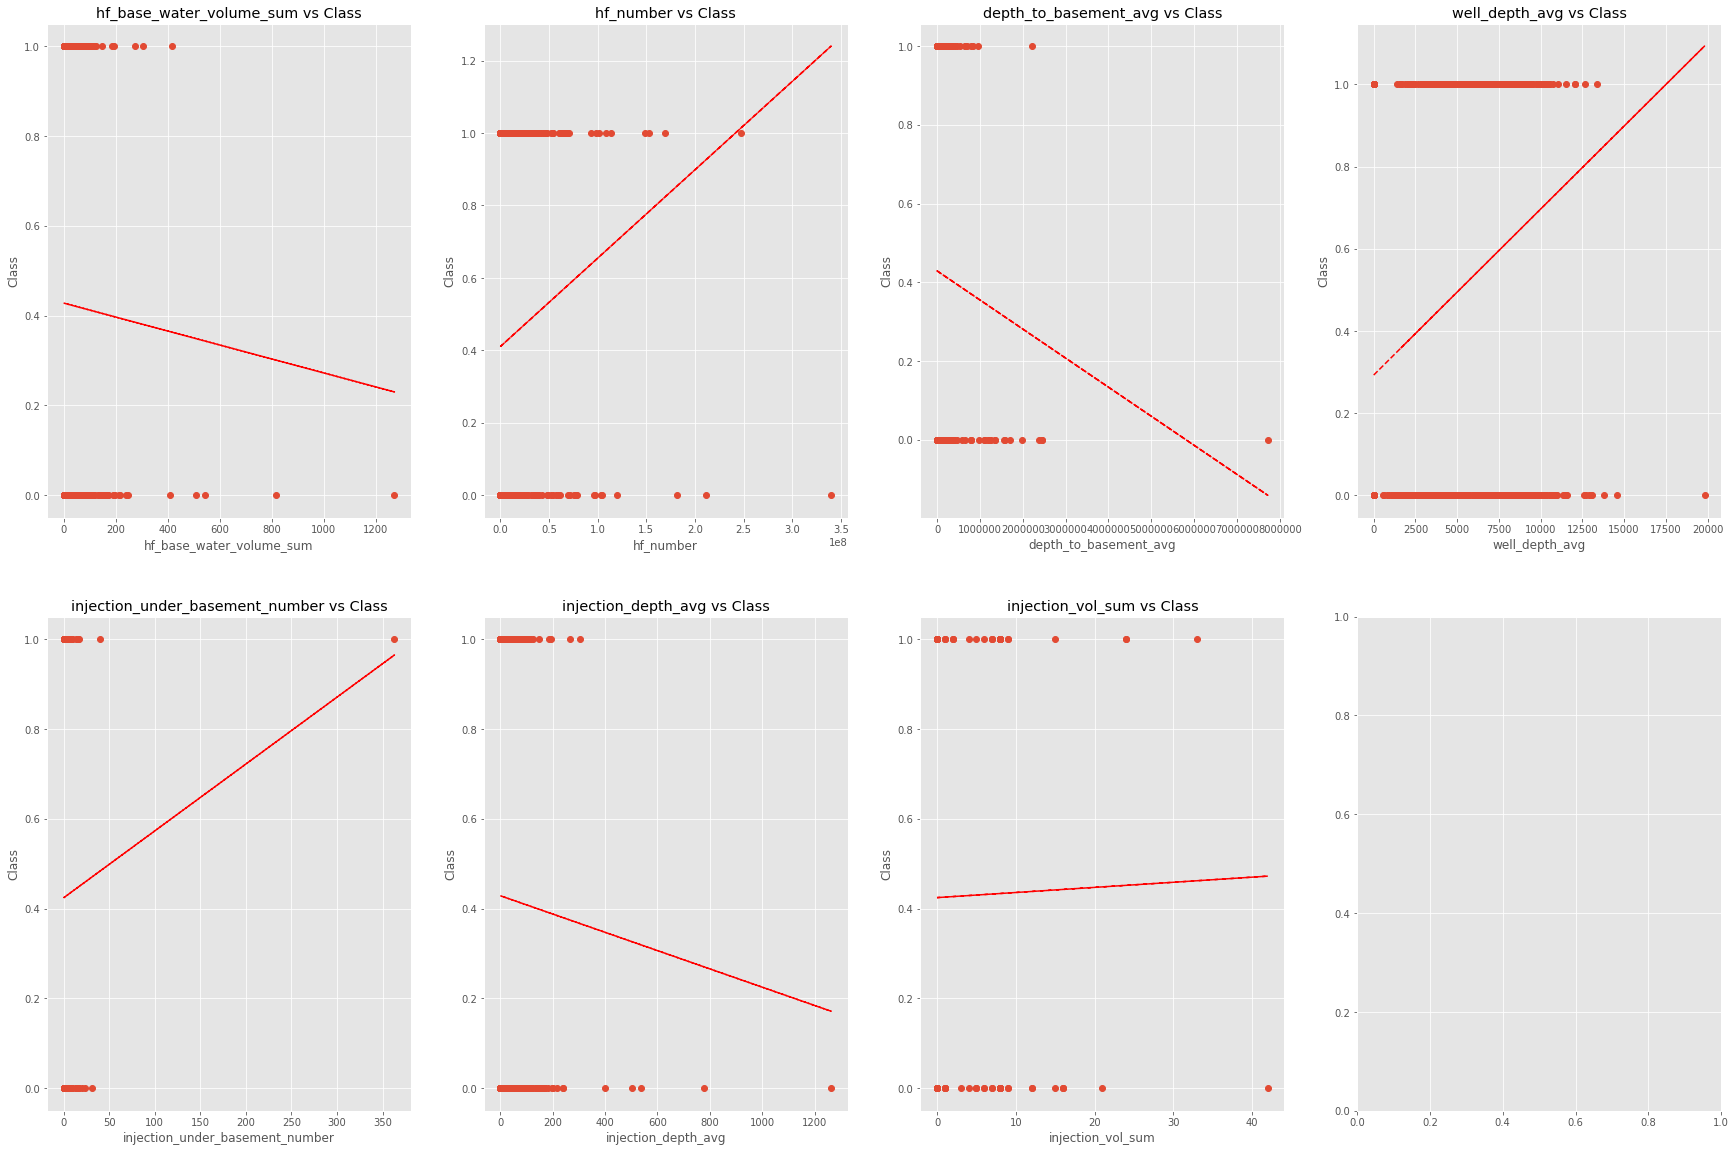

In [437]:
X = df.iloc[:,0:-1].values
y = df['class'].values
fig, axs = plt.subplots(nrows = 2, ncols=4, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, x_columns)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Class')
    ax.set_xlabel(col)
    ax.set_ylabel('Class')

# Logistic regression model construction

In [438]:
#features
X = df[x_columns].values
#labels
Y = df['class'].values

X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8, random_state=42)

mean_value = np.mean(X_train, axis=0)
std_value = np.std(X_train, axis=0)

feature_number = len(x_columns)
# X_train
for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]

#Print the data size
print('Original data：',X.shape,
     'Training data：',X_train.shape,
      'Testing data',X_test.shape)

print('Original data labels：',Y.shape,
     'Training data labels：',y_train.shape,
      'Testing data labels',y_test.shape)

feature_number = len(x_columns)


X_train=X_train.reshape(-1,feature_number)
X_test=X_test.reshape(-1,feature_number)


# Construct the logistic regression model
LR_model=LogisticRegression()

# Train the LR model
LR_model.fit(X_train,y_train)

# Calculate the accuracy of LR model on testing dataset
LR_model.score(X_test,y_test)

Original data： (1600, 7) Training data： (1280, 7) Testing data (320, 7)
Original data labels： (1600,) Training data labels： (1280,) Testing data labels (320,)


0.721875

# Show the coefficients of LR model

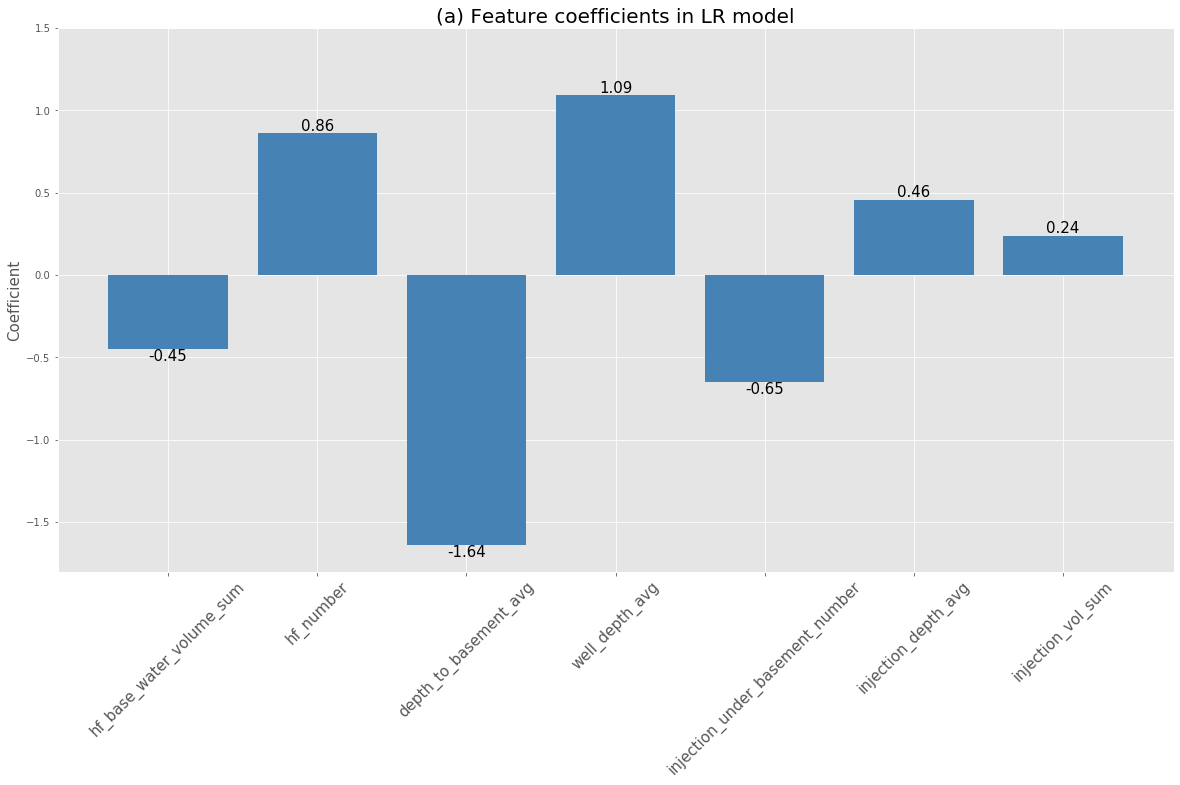

In [439]:
X = x_columns
Y = LR_model.coef_[0]
fig = plt.figure(figsize=(20, 10))
plt.bar(X,Y, color="steelblue")

for x,y in zip(X,Y):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=15)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=15)

# plt.xlabel("Feature", fontsize=15)
plt.ylabel("Coefficient", fontsize=15)
plt.title("(a) Feature coefficients in LR model", fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.ylim(-1.8, 1.5)
plt.show()

# Nueral network model construction

In [458]:
features = df[x_columns]
target = df['class']
feature_names = features.columns.tolist()
print(feature_names)

['hf_base_water_volume_sum', 'hf_number', 'depth_to_basement_avg', 'well_depth_avg', 'injection_under_basement_number', 'injection_depth_avg', 'injection_vol_sum']


In [459]:
class Net(nn.Module):
    def __init__(self,n_input, n_output):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(n_input, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, 8)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(8, n_output)

    def forward(self, x):
        lin1_out = self.linear1(x)
        relu_out1 = self.relu1(lin1_out)
        relu_out2 = self.relu2(self.linear2(relu_out1))
        return self.linear3(relu_out2)

In [460]:
def train(model, optimizer, criterion, data_loader):
    """
    The training method, to train the dataset
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.float().to(device), y.long().to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, feature_number))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    The validation method, to validate and test
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.float().to(device), y.long().to(device)
            a2 = model(X.view(-1, feature_number))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

# Train the NN model and test evaluation

In [461]:
# Define the hyperparameters
seed = 42
lr = 1e-3
batch_size = 8
test_batch_size = 8
n_epochs = 250

feature_number = len(feature_names)
NN_model = Net(feature_number,2)

In [462]:
Y = target.values
X = features.values
# data_tensor = TensorDataset(torch.tensor(X), torch.tensor(Y))

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train = X[indices[0]]
X_test = X[indices[1]]
Y_train = Y[indices[0]]
Y_test = Y[indices[1]]

mean_value = np.mean(X[indices[0]], axis=0)
std_value = np.std(X[indices[0]], axis=0)


for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

**Note: Although we set the seed. However, the training process is not always the same. The result in the report is one best attempt which reaches 80.3% accuracy on test dataset, but it is not guaranteed that we can trained the NN model to that state in each attempt. We set we stopped training when model reaches at that state for recurring the result in report, but this is not guaranteed. Besides, the statistics obtained below may be slightly different with those in report, but it will not influence the conclusion.**

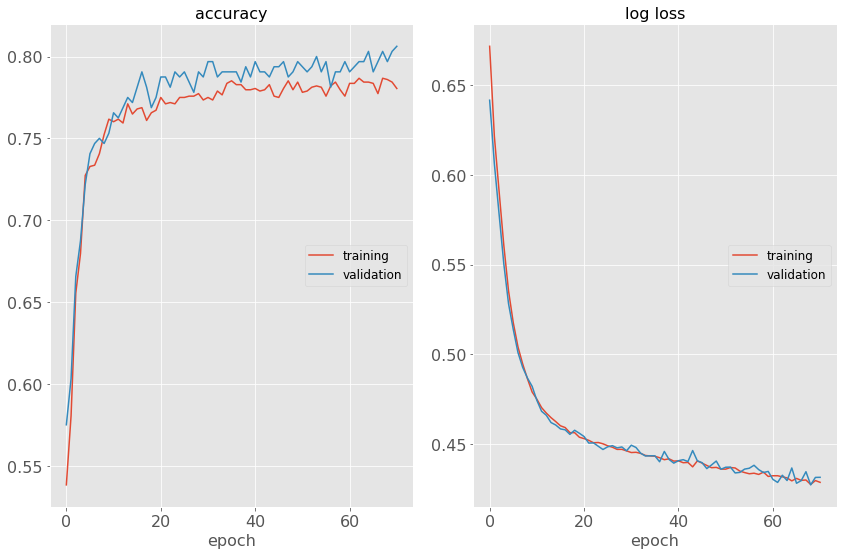

accuracy
	training         	 (min:    0.538, max:    0.787, cur:    0.780)
	validation       	 (min:    0.575, max:    0.806, cur:    0.806)
log loss
	training         	 (min:    0.427, max:    0.672, cur:    0.428)
	validation       	 (min:    0.427, max:    0.642, cur:    0.431)

Avg. Test Loss: 0.431  Avg. Test Accuracy: 0.806


In [463]:
set_seed(seed)
optimizer = torch.optim.Adam(NN_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(NN_model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(NN_model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    if round(validation_accuracy, 3) == 0.803:
        break


test_loss, test_accuracy = validate(NN_model, criterion, test_loader)  
print("")
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

# Feature Attribution by Captum

In [464]:
X_test_tensor = torch.from_numpy(X_test).float()
X_train_tensor = torch.from_numpy(X_train).float()

In [465]:
ig = IntegratedGradients(NN_model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(NN_model)
gs = GradientShap(NN_model)
fa = FeatureAblation(NN_model)

ig_attr_test = ig.attribute(X_test_tensor, target=1, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test_tensor, target=1)
dl_attr_test = dl.attribute(X_test_tensor, target=1)
gs_attr_test = gs.attribute(X_test_tensor, X_train_tensor, target=1)
fa_attr_test = fa.attribute(X_test_tensor, target=1)

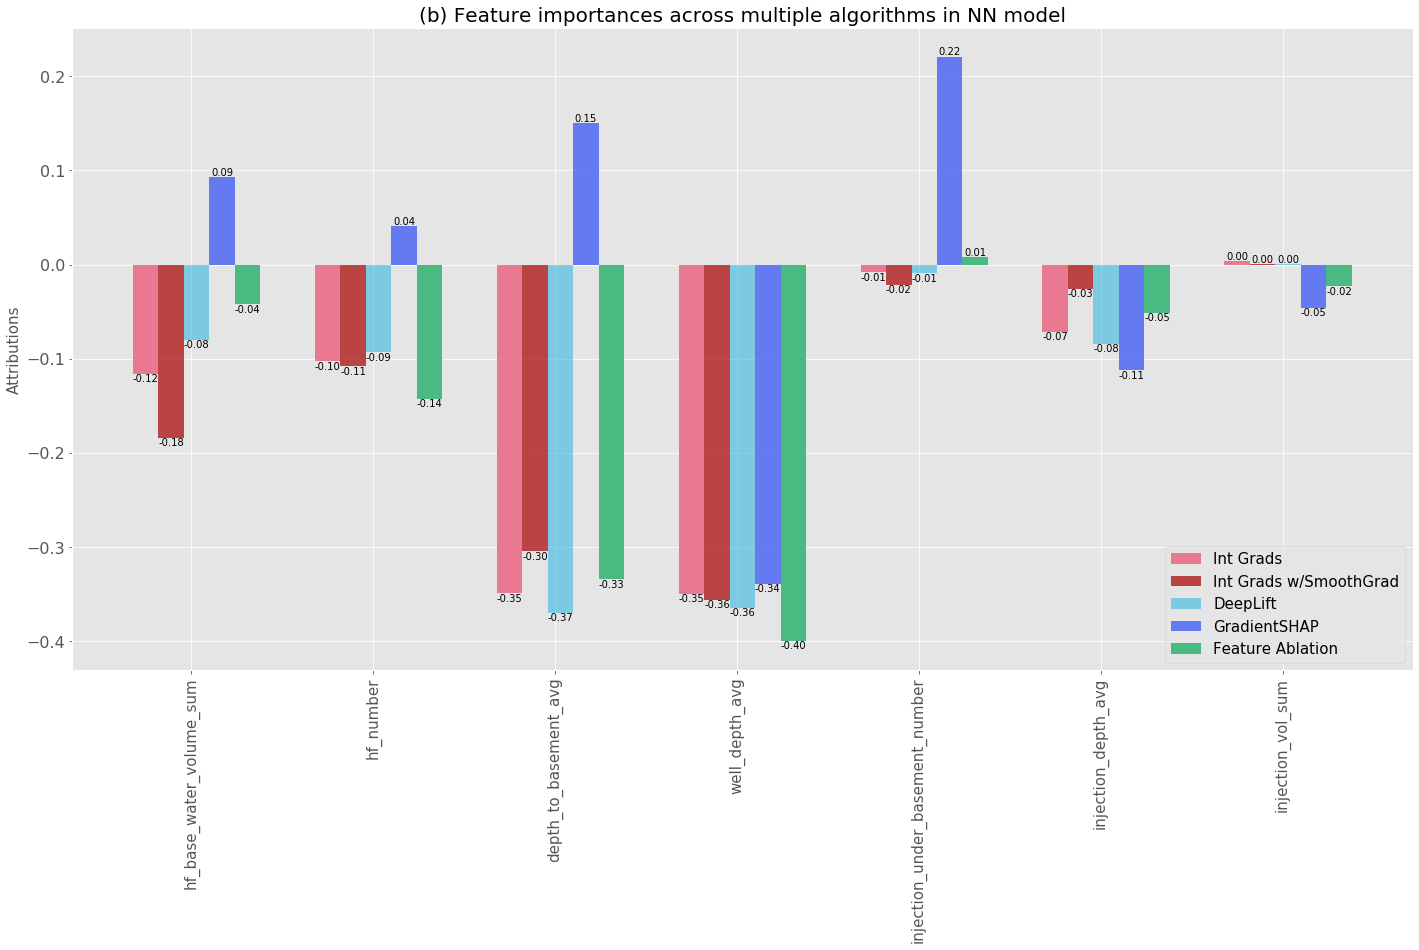

In [466]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test_tensor.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = NN_model.linear1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('(b) Feature importances across multiple algorithms in NN model', fontsize=20)
ax.set_ylabel('Attributions', fontsize=15)

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
# ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

for x,y in zip(x_axis_data,ig_attr_test_norm_sum):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=10)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=10)
        
for x,y in zip(x_axis_data + width,ig_nt_attr_test_norm_sum):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=10)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=10)
        
for x,y in zip(x_axis_data + 2 * width,dl_attr_test_norm_sum):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=10)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=10)
        
for x,y in zip(x_axis_data + 3 * width,gs_attr_test_norm_sum):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=10)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=10)
        
for x,y in zip(x_axis_data + 4 * width,fa_attr_test_norm_sum):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=10)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=10)
        

ax.set_xticks(x_axis_data + 0.25)
ax.set_xticklabels(x_axis_data_labels)
plt.xticks(rotation=90, fontsize=15)
plt.legend(legends, loc=4, fontsize=15)
plt.show()

# Test on all the dataset to reproduction

In [467]:
NN_model.eval()

test_features = features.values
test_labels = target.values 

for i in range(0, feature_number):
    test_features[:,i] = (test_features[:,i] - mean_value[i]) / std_value[i]

test_input_tensor = torch.from_numpy(test_features)

LR_out_classes = LR_model.predict(test_input_tensor)

out_probs = NN_model(test_input_tensor.float()).detach()
NN_out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()

### True Seismicity

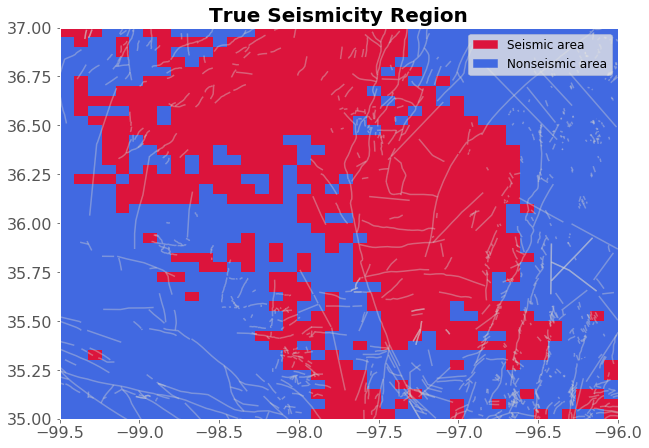

In [468]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 30))
ax1=fig.add_subplot(1,1,1)

# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('../datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='lightgrey')

lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = test_labels

i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax1.set_title('True Seismicity Region', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
ax1.legend(handles=[red_patch, blue_patch], fontsize=12)

# show map
plt.show()

### Seismicity predicted by LR model

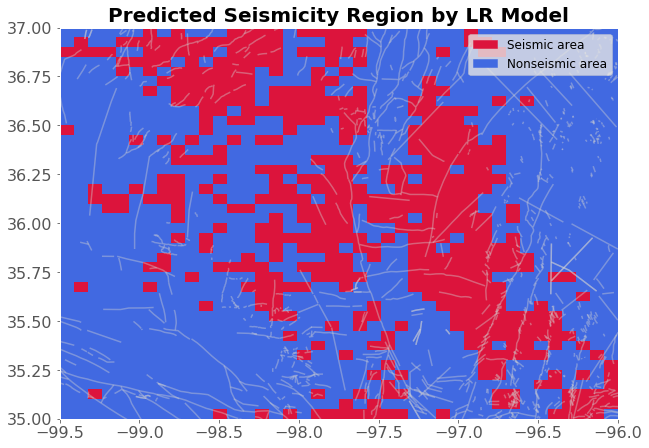

In [469]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 30))

ax2=fig.add_subplot(1,1,1)

# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('../datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='lightgrey')


lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x

plot_list = LR_out_classes

i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax2.set_xlim(-99.5, -96)
ax2.set_ylim(35, 37)
ax2.set_title('Predicted Seismicity Region by LR Model', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
ax2.legend(handles=[red_patch, blue_patch], fontsize=12)

# show map
plt.show()

### Seismicity predicted by NN model

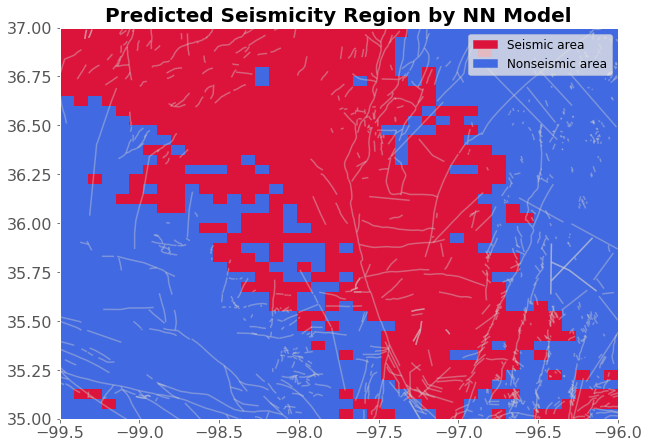

In [470]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 30))

ax3=fig.add_subplot(1,1,1)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('../datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax3, alpha=0.4,color='lightgrey')

lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x

plot_list = NN_out_classes

i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        if plot_list[i] == 0:
            ax3.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax3.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax3.set_xlim(-99.5, -96)
ax3.set_ylim(35, 37)
ax3.set_title('Predicted Seismicity Region by NN Model', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')

ax3.legend(handles=[red_patch, blue_patch], fontsize=12)
# show map
plt.show()

# Calculate evaluation measures

In [471]:
print("LR_acc:", accuracy_score(test_labels, LR_out_classes))
print("LR_precision:", precision_score(test_labels, LR_out_classes))
print("LR_recall:", recall_score(test_labels, LR_out_classes))
print("LR_F1-score:", f1_score(test_labels, LR_out_classes))

print("NN_acc:", accuracy_score(test_labels, NN_out_classes))
print("NN_precision:", precision_score(test_labels, NN_out_classes))
print("NN_recall:", recall_score(test_labels, NN_out_classes))
print("NN_F1-score:", f1_score(test_labels, NN_out_classes))

LR_acc: 0.705
LR_precision: 0.7023346303501945
LR_recall: 0.5308823529411765
LR_F1-score: 0.6046901172529312
NN_acc: 0.788125
NN_precision: 0.732605729877217
NN_recall: 0.7897058823529411
NN_F1-score: 0.7600849256900212


# Plot the confussion matrices

In [472]:
def confusion_matrix_(y_pred,y_true):
    '''
    params:
        y_pred:predicted labels
        y_true:true lables
    result:
        Plot confussion matrix
    '''
    CM = confusion_matrix(y_true,y_pred)
    
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(r'Confusion Matrix')
    ax1 = fig.add_subplot(2,1,1)
    sns.heatmap(CM,annot=True,cmap='Blues',linewidths=0.5,ax=ax1)
    ax1.set_xlabel('predicate')
    ax1.set_ylabel('true')
    
    (tn,fp,fn,tp) = CM.ravel()
    acc = accuracy_score(y_true, y_pred)
    pre0 = tn/(fn+tn); pre1 = tp/(tp+fp)
    recall0 = tn/(fp+tn); recall1 = tp/(tp+fn)
    f10 = 2*tn/(2*tn+fp+fn)
    f11 = 2*tp/(2*tp+fp+fn)
    col_labels = ['precision','recall','F1']
    row_labels = [' '*4+'0'+' '*4,' '*4+'1'+' '*4]
    table_vals = [[pre0,recall0,f10],[pre1,recall1,f11]]
    ax2 = fig.add_subplot(2,1,2)
    ax2.table(cellText=table_vals,rowLabels=row_labels,
              colLabels=col_labels,loc='center')
    ax2.text(0.35,0.6,
             r'''
            accuracy: {acc}
              '''.format(acc=acc),
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='black',
        transform=ax2.transAxes)
    ax2.axis('off')
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show() 

Text(0.5, 1, 'NN Model')

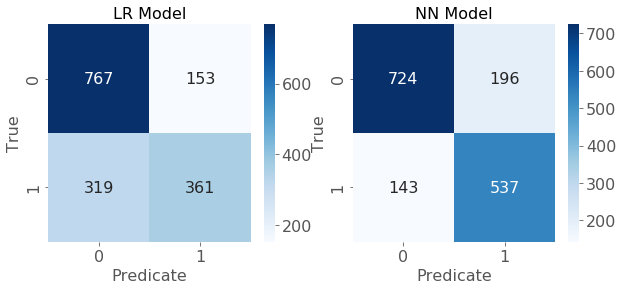

In [473]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
C=confusion_matrix(test_labels, LR_out_classes, labels=[0, 1])
LR_confusion_df=pd.DataFrame(C,index=[0, 1],columns=[0, 1])
sns.heatmap(LR_confusion_df,annot=True,fmt="d",cmap='Blues')

ax1.set_xlabel('Predicate')
ax1.set_ylabel('True')
ax1.set_title('LR Model')

ax2 = fig.add_subplot(1,2,2)
C=confusion_matrix(test_labels, NN_out_classes, labels=[0, 1])
NN_confusion_df=pd.DataFrame(C,index=[0, 1],columns=[0, 1])
sns.heatmap(NN_confusion_df,annot=True,fmt="d",cmap='Blues')

ax2.set_xlabel('Predicate')
ax2.set_ylabel('True')
ax2.set_title('NN Model')

# Plot the ROC curves

<Figure size 432x288 with 0 Axes>

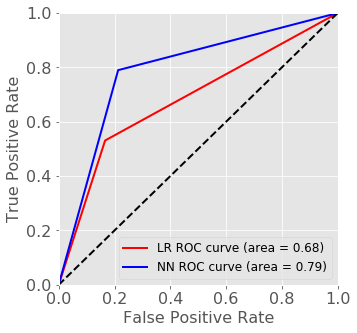

In [474]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
LR_fpr,LR_tpr,LR_threshold = roc_curve(test_labels, LR_out_classes) # calculate TPR and FPR of LR
NN_fpr,NN_tpr,NN_threshold = roc_curve(test_labels, NN_out_classes) # calculate TPR and FPR of NN
LR_roc_auc = auc(LR_fpr,LR_tpr) # calculate auc of LR
NN_roc_auc = auc(NN_fpr,NN_tpr) # calculate auc of NN


# ROC curves Plot
plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(LR_fpr, LR_tpr, color='r',
         lw=lw, label='LR ROC curve (area = %0.2f)' % LR_roc_auc)
plt.plot(NN_fpr, NN_tpr, color='b',
         lw=lw, label='NN ROC curve (area = %0.2f)' % NN_roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Save the models

In [475]:
import joblib
# LR
joblib.dump(LR_model, "../model/LR.dat")
# NN
NN_model.parameters()
path = "../model/NN.pt"
torch.save(NN_model.state_dict,path)